In [1]:
from astropy.io import fits # to read in FITS files
from astropy.wcs import WCS # to read coordinates
from reproject import reproject_interp # to align images
import numpy as np # math applied to arrays (important, no need to read pixel for pixel!)
from matplotlib import pyplot as plt # plot library 
from astropy.visualization import ZScaleInterval # create minimum and maximum Z values for plotting 
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob # finding pathnames
import os # os.path to manipulate file paths 
from scipy.stats import rankdata
from astropy.stats import sigma_clip as astropy_sigma_clip
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
# Change the data with whatever fit you're using.
# Easiest to 'copy relative path' if you're using the GitHub folder.
# Don't forget to change \ to /.
fit_g = "NGC_4449_g_stack_astrometry.fits"
fit_r = "NGC_4449_r_stack_astrometry.fits"
fit_L = 'NGC_4449_L_stack_astrometry.fits'
fit_ha = 'NGC_4449_ha_stack_stephanie_astrometry.fits'

# Returns the header and data of a .fit file.
def get_data(data_im):
    hdu = fits.open(data_im)[0]
    header = hdu.header 
    data = hdu.data
    wcs = WCS(hdu.header)
    return header, data, wcs

header_L, dat_L, wcs_L = get_data(fit_L)
header_g, dat_g, wcs_g = get_data(fit_g)
header_r, dat_r, wcs_r = get_data(fit_r)
header_ha, dat_ha, wcs_ha = get_data(fit_ha)


In [3]:
# Aligns image with the reference coordinates.
def reproject_image(image_filename, wcs_ref):
    hdu = fits.open(image_filename)[0]
    array, footprint = reproject_interp(hdu, wcs_ref)
    return array

# Reference coordinates.
wcs_ref = WCS(header_g)

aligned_g = reproject_image(fit_g, wcs_ref)
print("Align g: done!")
aligned_r = reproject_image(fit_r, wcs_ref)
print("Align r: done!")
aligned_ha = reproject_image(fit_ha, wcs_ref)
print("Align h-alpha: done!")
aligned_L = reproject_image(fit_L, wcs_ref)
print("Align L: done!")


Align g: done!
Align r: done!
Align h-alpha: done!
Align L: done!


In [4]:
# Calculate standarddeviation on counts
def std_counts(image):
    return np.sqrt(image)

# Calculates standarddeviation on magnitude
def std_mag(image, err_zp):
    return np.sqrt((-2.5/np.log(10)*np.sqrt(image)/image)**2 + err_zp**2)


# Function to calculate distances from the center
def calc_distance(image, x_center, y_center):
    # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)
    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances

# Calculate background noise
def calc_background(image, xmin, xmax, ymin, ymax):
    background_region = image[ymin:ymax, xmin:xmax]
    average = np.mean(background_region)
    return average

# Function to calculate the flux
def convert_to_magnitude(image, zero_point):
    # Add a min flux to avoid log(0)
    min_flux = 1e-10
    flux = -2.5 * np.log10(np.maximum(image,min_flux)/60) + zero_point
    return flux

# Calculates the color index
def calc_color_index(filter1, filter2):
    color_index = filter1 - filter2
    return color_index

# Converts g' - r' values to B - V
def gr_to_BV(color_index):
    return ((color_index/1.10) + 0.19)



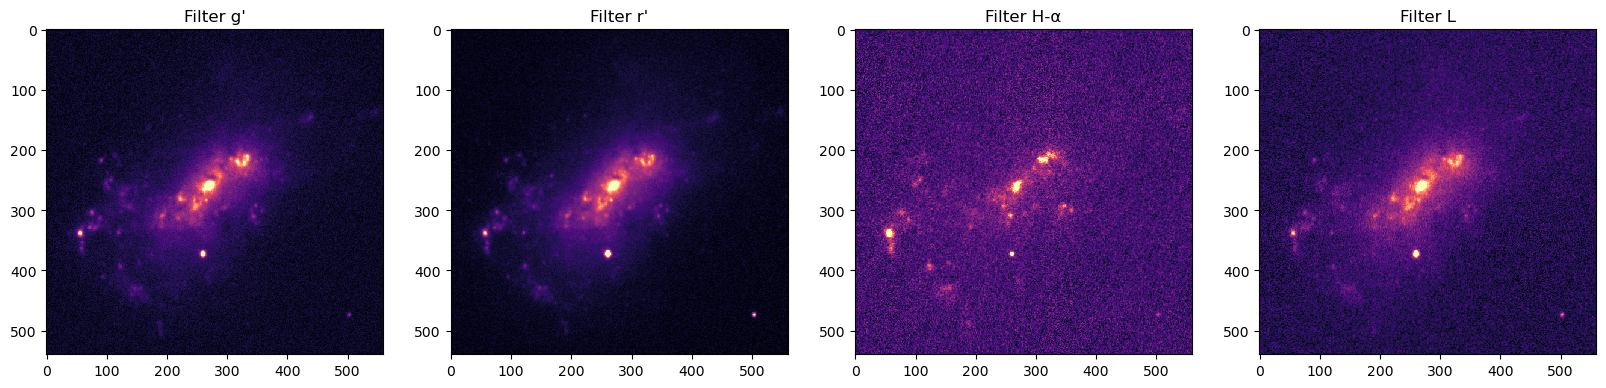

In [5]:
# Calculate distance from the center of each point
hdu = fits.open(fit_g)[0]
image_data = aligned_g
wcs = WCS(hdu.header)

# Define the ICRS coordinates of the galaxy center
ra_center = 187.046325  # Right Ascension in degrees
dec_center = 44.093558  # Declination in degrees

# Create a SkyCoord 
sky_coord = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame='icrs')

# Convert WCS coordinates to pixel coordinates
x_center, y_center = wcs.world_to_pixel(sky_coord)

distances = calc_distance(image_data, x_center, y_center)

# x, y limits to crop images (1600, 2400, 1800, 2400 to see only NGC 4449)
x_min, x_max, y_min, y_max = 1720, 2280, 1800, 2340

# Crop the images
cropped_g= aligned_g[y_min:y_max, x_min:x_max]
cropped_r = aligned_r[y_min:y_max, x_min:x_max]
cropped_ha = aligned_ha[y_min:y_max, x_min:x_max]
cropped_L = aligned_L[y_min:y_max, x_min:x_max]
cropped_distances = distances[y_min:y_max, x_min:x_max]

# Visualize the cropped images
quantiles_g = np.percentile(cropped_g, (0.1, 99.9))
quantiles_r = np.percentile(cropped_r, (0.1, 99.9))
quantiles_ha = np.percentile(cropped_ha, (0.1, 99.9))
quantiles_L = np.percentile(cropped_L, (0.1, 99.9))
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cropped_g, cmap='magma', vmin = quantiles_g[0], vmax = quantiles_g[1], interpolation = 'nearest')
axs[0].set_title("Filter g'")
axs[1].imshow(cropped_r, cmap='magma', vmin = quantiles_r[0], vmax = quantiles_r[1], interpolation = 'nearest')
axs[1].set_title("Filter r'")
axs[2].imshow(cropped_ha, cmap='magma', vmin = quantiles_ha[0], vmax = quantiles_ha[1], interpolation = 'nearest')
axs[2].set_title("Filter H-α")
axs[3].imshow(cropped_L, cmap='magma', vmin = quantiles_L[0], vmax = quantiles_L[1], interpolation = 'nearest')
axs[3].set_title('Filter L')

plt.show()

no_bg_g = cropped_g - 244.13093010864273
no_bg_r = cropped_r - 332.6516227990238
no_bg_ha = cropped_ha - 101.7104743544874
no_bg_L = cropped_L - 1217.66174153108


In [6]:
# Remove hashtags to enable sigma clipping
def sigma_clip(image, sigma, maxiters):
    #clipped_data = astropy_sigma_clip(image, sigma=sigma, maxiters=maxiters, cenfunc='median', stdfunc='std')
    #Fill up masked points with NaN values
    #return clipped_data.filled(np.nan)
    return image

sigma = 10
maxiters = 3
clipped_ha = sigma_clip(no_bg_ha, sigma, maxiters)
clipped_g = sigma_clip(no_bg_g, sigma, maxiters)
clipped_L = sigma_clip(no_bg_L, sigma, maxiters)
clipped_r = sigma_clip(no_bg_r, sigma, maxiters)

In [7]:
zero_point = 25

zero_point_ha = 0
zero_point_L = 0
zero_point_r = 20.44166 + 0.055
zero_point_g = 20.29604 + 0.055

magnitude_ha = convert_to_magnitude(clipped_ha, zero_point_ha)
magnitude_L = convert_to_magnitude(clipped_L, zero_point_L)
magnitude_r = convert_to_magnitude(clipped_r, zero_point_r)
magnitude_g = convert_to_magnitude(clipped_g, zero_point_g)



color_index_g_min_r = calc_color_index(magnitude_g, magnitude_r)
print(np.max(magnitude_ha))
print(np.min(magnitude_ha))

29.44537812595911
4.510156107564494


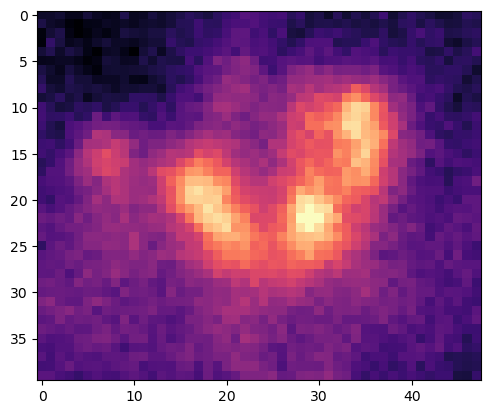

In [44]:
# Select area of gridmap you want to use for CMD
# Use the values of the axes of the gridmap
x_min, x_max, y_min, y_max = 75, 87, 50, 60

# Make sure this is the same as in sections.ipynb
region_size_define = 4

# Plot region
area_g = no_bg_g[(region_size_define*y_min):(region_size_define*y_max), (region_size_define*x_min):(region_size_define*x_max)]
quantiles = np.percentile(area_g, (0.1, 99.9))
plt.imshow(area_g, cmap='magma', vmin = quantiles[0], vmax = quantiles[1], interpolation = 'nearest')
plt.show()

In [45]:
# Calculate distance to center of chosen region

def distance_region(image):
     # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)
    # Calculate center of region
    x_center, y_center = (np.max(x_indices)/2), (np.min(y_indices)/2)
    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

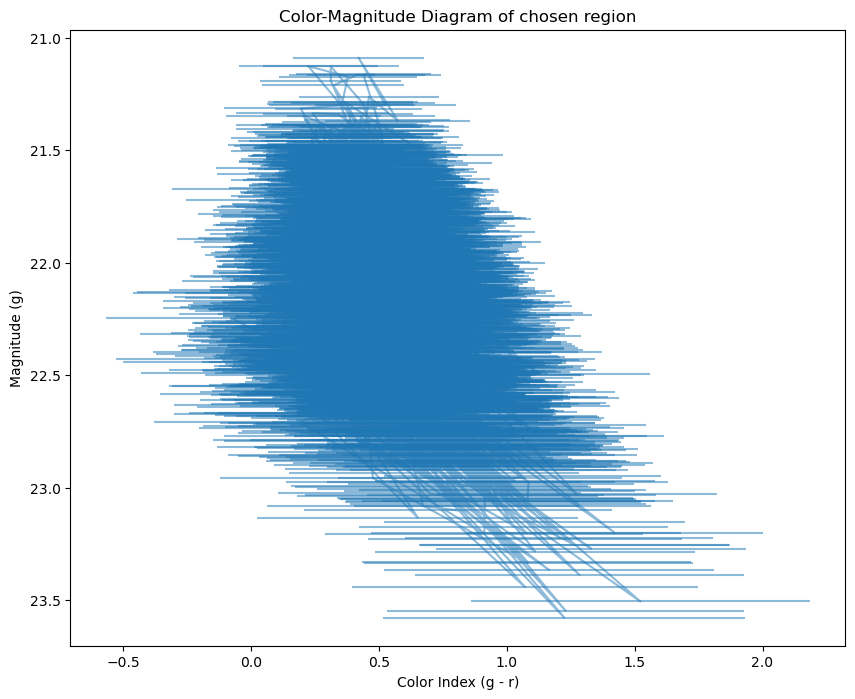

In [49]:
# Crop image to only the region chosen on the gridmap
# Multiple by region_size_define to get original pixel coordinates instead of binned ones.
region_g = magnitude_g[(region_size_define*x_min):(region_size_define*x_max), (region_size_define*y_min):(region_size_define*y_max)]
region_r = magnitude_r[(region_size_define*x_min):(region_size_define*x_max), (region_size_define*y_min):(region_size_define*y_max)]
distances = distance_region(region_g)

color_index = calc_color_index(region_g, region_r)

color_index_BV = gr_to_BV(color_index)


std_region_g = std_mag(no_bg_g[(region_size_define*x_min):(region_size_define*x_max), (region_size_define*y_min):(region_size_define*y_max)], 0)
std_region_r = std_mag(no_bg_r[(region_size_define*x_min):(region_size_define*x_max), (region_size_define*y_min):(region_size_define*y_max)], 0)
std_color_index = np.sqrt(std_region_g**2 + std_region_r**2)

plt.figure(figsize=(10, 8))
plt.scatter(color_index_BV.flatten(), region_g.flatten(), alpha=0.5, c=distances, cmap='magma')
plt.xlabel('Color Index (g - r)')
plt.ylabel('Magnitude (g)')
plt.title('Color-Magnitude Diagram of chosen region')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.colorbar()
plt.grid(True)



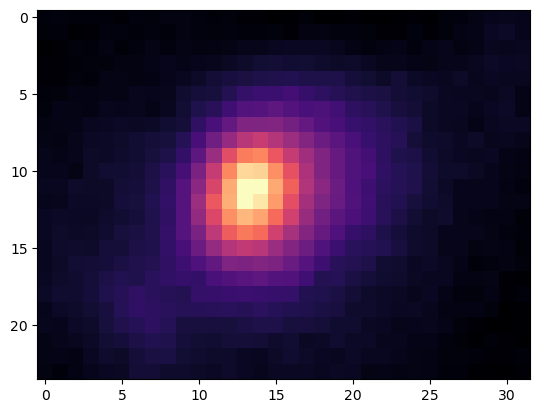

In [47]:
# Select area of gridmap you want to use for CMD
# Use the values of the axes of the gridmap
x_min2, x_max2, y_min2, y_max2 = 64, 72, 62, 68

# Make sure this is the same as in sections.ipynb
region_size_define = 4

# Plot region
area_g2 = no_bg_g[(region_size_define*y_min2):(region_size_define*y_max2), (region_size_define*x_min2):(region_size_define*x_max2)]
quantiles2 = np.percentile(area_g2, (0.1, 99.9))
plt.imshow(area_g2, cmap='magma', vmin = quantiles2[0], vmax = quantiles2[1], interpolation = 'nearest')
plt.show()

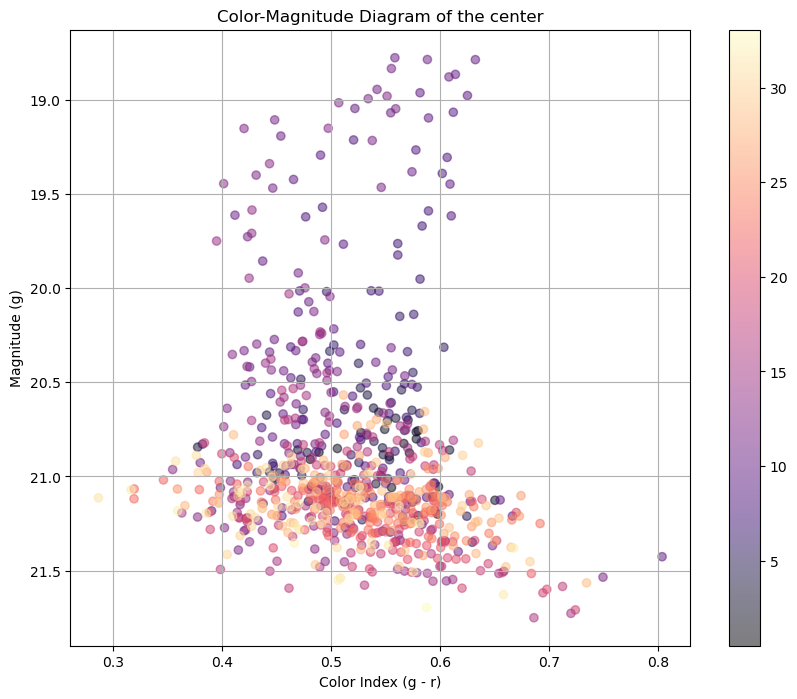

In [48]:
# Crop image to only the region chosen on the gridmap
# Multiple by region_size_define to get original pixel coordinates instead of binned ones.
region_g2 = magnitude_g[(region_size_define*x_min2):(region_size_define*x_max2), (region_size_define*y_min2):(region_size_define*y_max2)]
region_r2 = magnitude_r[(region_size_define*x_min2):(region_size_define*x_max2), (region_size_define*y_min2):(region_size_define*y_max2)]
distances2 = distance_region(region_g2)

color_index2 = calc_color_index(region_g2, region_r2)

color_index_BV2 = gr_to_BV(color_index2)


std_region_g2 = std_mag(no_bg_g[(region_size_define*x_min2):(region_size_define*x_max2), (region_size_define*y_min2):(region_size_define*y_max2)], 0)
std_region_r2 = std_mag(no_bg_r[(region_size_define*x_min2):(region_size_define*x_max2), (region_size_define*y_min2):(region_size_define*y_max2)], 0)
std_color_index2 = np.sqrt(std_region_g2**2 + std_region_r2**2)

plt.figure(figsize=(10, 8))
#plt.errorbar(color_index_BV.flatten(), region_g.flatten(), xerr=std_color_index.flatten(), alpha=0.5)
plt.scatter(color_index_BV2.flatten(), region_g2.flatten(), alpha=0.5, c=distances2, cmap='magma')
plt.xlabel('Color Index (g - r)')
plt.ylabel('Magnitude (g)')
plt.title('Color-Magnitude Diagram of the center')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.colorbar()
plt.grid(True)
